In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    silhouette_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
%matplotlib inline

2025-04-18 18:58:00.240224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 18:58:00.281241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 18:58:01.042087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_csv('Датасет №1_Airline Passenger Satisfaction_mod.csv', parse_dates=['Date'])

num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns.drop(['satisfaction', 'Date'])

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

le = LabelEncoder()
df['satisfaction'] = le.fit_transform(df['satisfaction'])
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df.drop('Date', axis=1, inplace=True)

scaler = StandardScaler()
X = scaler.fit_transform(df.drop('satisfaction', axis=1))
y = df['satisfaction']

/tmp/ipykernel_372149/1622910587.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


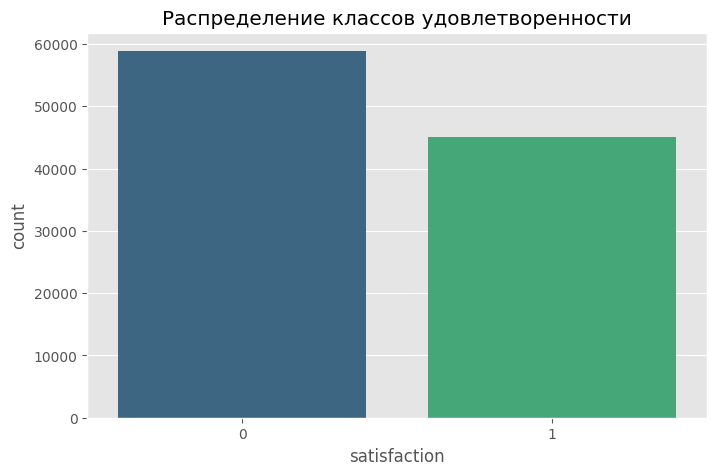

In [3]:
plt.figure(figsize=(8,5))
sns.countplot(x=y, palette='viridis')
plt.title('Распределение классов удовлетворенности')
plt.show()

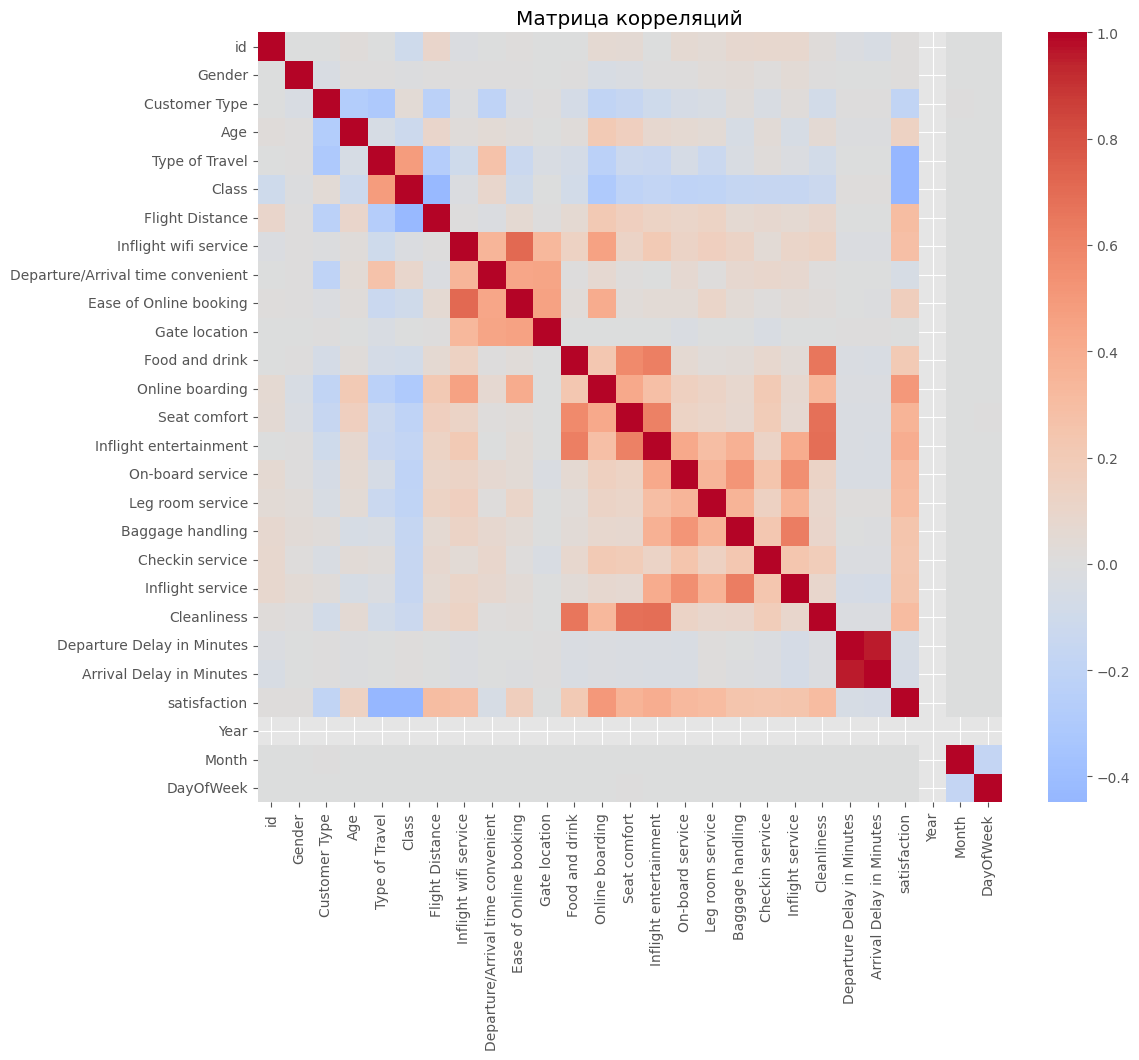

In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

<Figure size 1500x800 with 0 Axes>

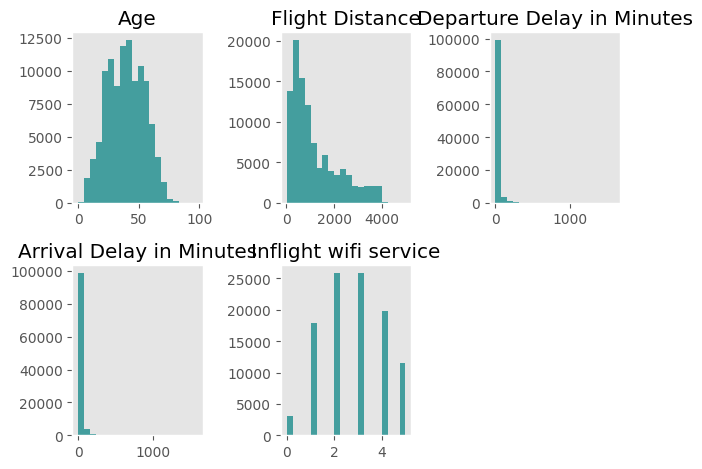

In [5]:
selected_columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 
                   'Arrival Delay in Minutes', 'Inflight wifi service']

plt.figure(figsize=(15, 8))
df[selected_columns].hist(
    bins=20,
    layout=(2, 3),
    grid=False,
    color='teal',
    alpha=0.7
)
plt.tight_layout()
plt.show()

In [ ]:
results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    metrics = {
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred)
    }
    results.append(metrics)
results_df = pd.DataFrame(results)
print("\nСравнение классификаторов:")
display(results_df.style.background_gradient(cmap='viridis', subset=results_df.columns[1:]))

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


clustering_algorithms = {
    "K-Means (k=2)": KMeans(n_clusters=2),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Agglomerative (k=2)": AgglomerativeClustering(n_clusters=2)
}

plt.figure(figsize=(15,5))
for i, (name, algorithm) in enumerate(clustering_algorithms.items(), 1):
    labels = algorithm.fit_predict(X_pca)
    
    plt.subplot(1,3,i)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='viridis')
    plt.title(f"{name}\nSilhouette: {silhouette_score(X_pca, labels):.2f}")
    
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

assert 'X_train' in locals(), "Ошибка: данные не были разделены на train/test"
history = model.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0
)

nn_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nНейронная сеть - Classification Report:")
print(classification_report(y_test, nn_pred))

In [ ]:
final_comparison = pd.concat([
    results_df,
    pd.DataFrame([{
        "Classifier": "Neural Network",
        "Accuracy": accuracy_score(y_test, nn_pred),
        "Precision": precision_score(y_test, nn_pred),
        "Recall": recall_score(y_test, nn_pred),
        "F1": f1_score(y_test, nn_pred),
        "ROC AUC": roc_auc_score(y_test, nn_pred)
    }])
], ignore_index=True).sort_values('F1', ascending=False)